In my work I often come across probabilistic models where there are strong correlations between parameters.
This certainly isn't a special feature of the problems that I work on, and the general advice from MCMC practitioners is that we should reparameterize our models in some form that removes the covariances, but this isn't always practical.
One of the reasons why [emcee](https://emcee.readthedocs.io) has been popular in astrophysics (I think) is that it uses an "affine invariant" algorithm.
This means that when you use emcee, the performance will be (more-or-less) the same for any problems that are affine transformations of each other.
In other words, it doesn't care about translations, rotations, or scalings of the parameters.

Standard [HMC](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo) methods such as the [NUTS](https://arxiv.org/abs/1111.4246) algorithm implemented in state-of-the-art libraries like [PyMC3](https://docs.pymc.io/) and [Stan](http://mc-stan.org/) do not have this property.
[Note: it is actually possible to construct an affine invariant NUTS sampler using some of the ideas from emcee, but there are some limitations and this will hopefully be the topic of a paper that I write someday...]
The performance of this method is generally very sensitive to the "metric" or "mass matrix" that is used and changes in parameterization can make a huge difference in the efficiency of sampling using these packages.
To deal with covariances, Stan has support for learning the off-diagonal elements of the mass matrix during burn-in.
The basic idea is that (in the Gaussian case) the optimal mass matrix will be equal to the inverse covariance of the posterior.
Therefore, you can estimate the sample covariance of burn-in chains and use that as the inverse mass matrix in subsequent samplings.
While PyMC3 has the machinery to support this, out of the box it only supports learning of the *diagonal* elements of the mass matrix during the tuning phase (as far as I can tell - please correct me if I'm wrong!).

In this blog post, I demonstrate how covariances can cause serious problems for PyMC3 on a simple (but not contrived) toy problem and then I show a way that you can use the existing features in PyMC3 to implement a tuning schedule similar to the one used by Stan and fit for the full dense mass matrix.
I have found that this can have a *huge* effect (a few orders of magnitude in the example shown here) on the computational efficiency of PyMC3 on the types of problems that are common in astrophysics.

## Sampling an isotropic Gaussian

First, let's look at how fast PyMC3 can sample an isotropic 5-D Gaussian.

In [1]:
import time
import warnings
import pymc3 as pm
import arviz as az

warnings.filterwarnings("ignore")

print("PyMC3 version {0}".format(pm.__version__))

ndim = 5

with pm.Model() as simple_model:
    pm.Normal("x", shape=(ndim,))

strt = time.time()
with simple_model:
    simple_trace = pm.sample(
        draws=3000, tune=3000, random_seed=42, chains=2, return_inferencedata=True
    )

    # About half the time is spent in tuning so correct for that
    simple_time = 0.5 * (time.time() - strt)

stats = az.summary(simple_trace)
simple_time_per_eff = simple_time / stats.ess_bulk.values.min()
print("time per effective sample: {0:.5f} ms".format(simple_time_per_eff * 1000))

PyMC3 version 3.11.5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [x]


Sampling 2 chains for 3_000 tune and 3_000 draw iterations (6_000 + 6_000 draws total) took 5 seconds.


time per effective sample: 1.34803 ms


On my laptop with two CPUs, I find that the computational cost per effective sample is a fraction of a millisecond.
That's how things should be!

## Sampling a covariant Gaussian

Now let's try an example where the dimensions of our Gaussian are correlated and see how the default performance of PyMC3 compares.
First, let's take a look at a [corner plot](https://corner.readthedocs.io) of the posterior that we're targeting.

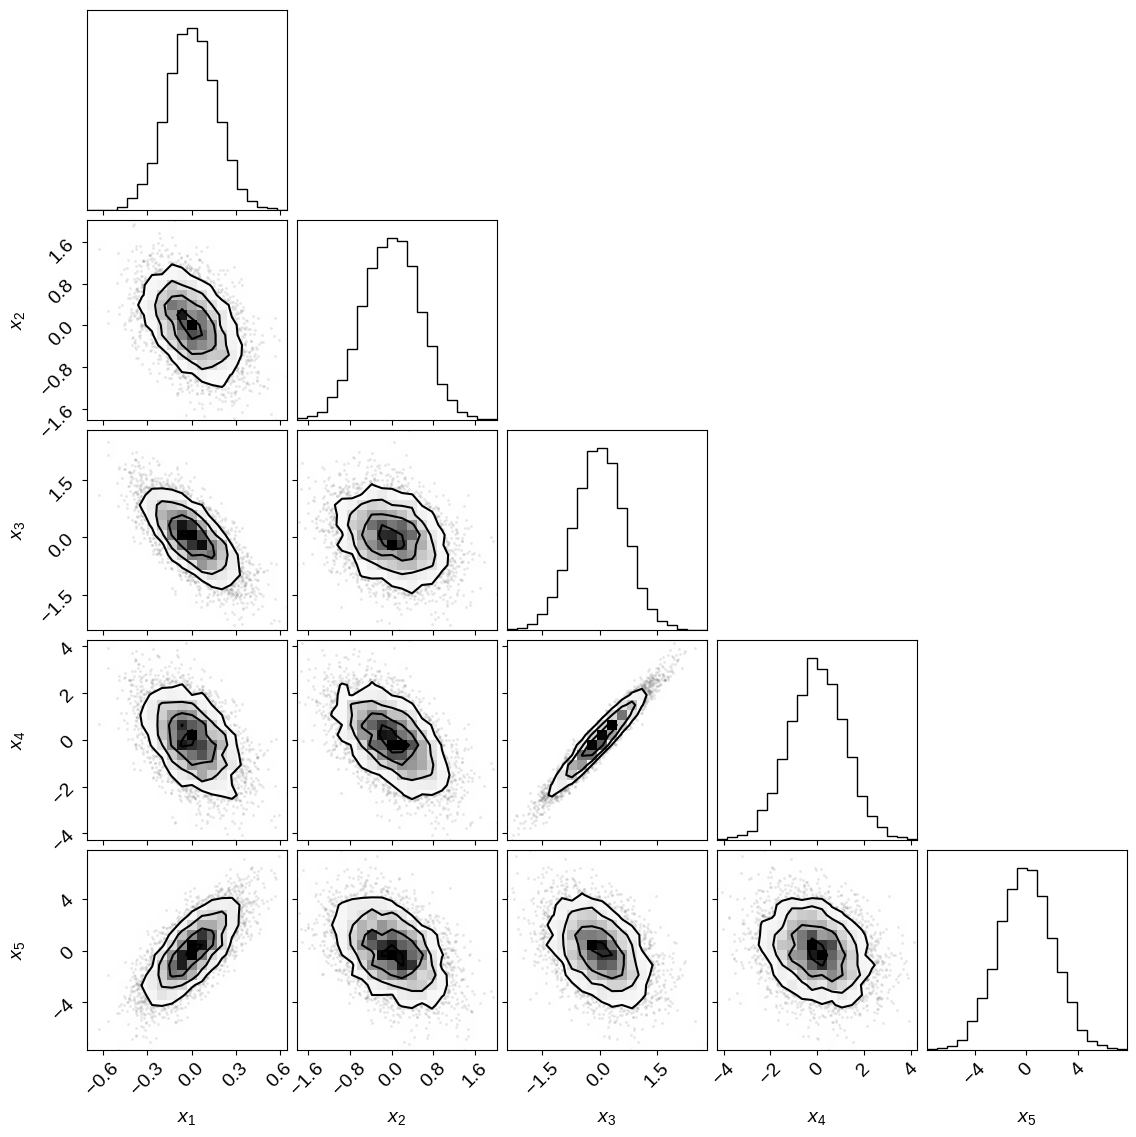

In [2]:
import numpy as np

import corner  # https://corner.readthedocs.io

# Generate a random positive definite matrix
np.random.seed(42)
L = np.random.randn(ndim, ndim)
L[np.diag_indices_from(L)] = 0.1 * np.exp(L[np.diag_indices_from(L)])
L[np.triu_indices_from(L, 1)] = 0.0
cov = np.dot(L, L.T)

# Draw samples from this Gaussian and plot
samples = np.random.multivariate_normal(np.zeros(ndim), cov, size=5000)
corner.corner(samples, labels=["$x_{{{0}}}$".format(i) for i in range(1, ndim + 1)]);

This plot will look familiar to any astronomers reading this (and probably some readers from other fields) because our parameters are often correlated and the dynamic range of the parameters can vary drastically.
If you used emcee to sample this posterior and the isotropic case above, you would get identical performance (albeit somewhat worse performance than PyMC3) but, as we'll see, the same is not true of PyMC3.
Let's try to sample this probability density using PyMC3's default settings.

In [3]:
with pm.Model() as model:
    pm.MvNormal("x", mu=np.zeros(ndim), chol=L, shape=(ndim,))

with model:
    strt = time.time()
    default_trace = pm.sample(
        draws=3000, tune=3000, random_seed=42, chains=2, return_inferencedata=True
    )
    default_time = 0.5 * (time.time() - strt)

stats = az.summary(default_trace)
default_time_per_eff = default_time / stats.ess_bulk.values.min()
print("time per effective sample: {0:.5f} ms".format(default_time_per_eff * 1000))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [x]


Sampling 2 chains for 3_000 tune and 3_000 draw iterations (6_000 + 6_000 draws total) took 1083 seconds.
The acceptance probability does not match the target. It is 0.8914101254030794, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


time per effective sample: 2003.80742 ms


Yes, the units here are the same and the computational efficiency is orders of magnitude worse than the isotropic case.
The standard recommendation would be to re-parameterize (we can see that that's what PyMC3 is telling us to do here too), but I'm not really clever or patient enough to do that in every case.
So, let's automate this following the procedure from Stan.

## Learning the mass matrix in PyMC3

In this section, I will demonstrate how we can use the machinery included in the current release of PyMC3 to fit for a dense mass matrix during burn-in.
First, let's choose a tuning schedule roughly following section 34.2 from the [Stan manual](https://github.com/stan-dev/stan/releases/download/v2.17.0/stan-reference-2.17.0.pdf).

In [4]:
n_start = 25
n_burn = 500
n_tune = 5000
n_window = n_start * 2 ** np.arange(np.floor(np.log2((n_tune - n_burn) / n_start)))
n_window = np.append(n_window, n_tune - n_burn - np.sum(n_window))
n_window = n_window.astype(int)

Next, here's a function that takes in a MultiTrace object from PyMC3, estimates the sample covariance, and builds a NUTS step for use in the `sample` method.

In [5]:
from pymc3.step_methods.hmc.quadpotential import QuadPotentialFull


def get_step_for_trace(
    trace=None, model=None, regular_window=5, regular_variance=1e-3, **kwargs
):
    model = pm.modelcontext(model)

    # If not given, use the trivial metric
    if trace is None:
        potential = QuadPotentialFull(np.eye(model.ndim))
        return pm.NUTS(potential=potential, **kwargs)

    # Loop over samples and convert to the relevant parameter space;
    # I'm sure that there's an easier way to do this, but I don't know
    # how to make something work in general...
    samples = np.empty((len(trace) * trace.nchains, model.ndim))
    i = 0
    for chain in trace._straces.values():
        for p in chain:
            samples[i] = model.bijection.map(p)
            i += 1

    # Compute the sample covariance
    cov = np.cov(samples, rowvar=0)

    # Stan uses a regularized estimator for the covariance matrix to
    # be less sensitive to numerical issues for large parameter spaces.
    # In the test case for this blog post, this isn't necessary and it
    # actually makes the performance worse so I'll disable it, but I
    # wanted to include the implementation here for completeness
    N = len(samples)
    cov = cov * N / (N + regular_window)
    cov[np.diag_indices_from(cov)] += (
        regular_variance * regular_window / (N + regular_window)
    )

    # Use the sample covariance as the inverse metric
    potential = QuadPotentialFull(cov)
    return pm.NUTS(potential=potential, **kwargs)

Finally, we can combine our tuning schedule with this proposal estimator to automatically learn the mass matrix during burn-in.

In [6]:
np.random.seed(42)

strt = time.time()
with model:
    start = None
    burnin_trace = None
    for steps in n_window:
        step = get_step_for_trace(burnin_trace, regular_window=0)
        burnin_trace = pm.sample(
            start=start,
            tune=steps,
            draws=2,
            step=step,
            compute_convergence_checks=False,
            discard_tuned_samples=False,
            return_inferencedata=False,
        )
        start = [t[-1] for t in burnin_trace._straces.values()]

    step = get_step_for_trace(burnin_trace, regular_window=0)
    dense_trace = pm.sample(
        draws=5000, tune=n_burn, step=step, start=start, return_inferencedata=True
    )
    factor = 5000 / (5000 + np.sum(n_window + 2) + n_burn)
    dense_time = factor * (time.time() - strt)

stats = az.summary(dense_trace)
dense_time_per_eff = dense_time / stats.ess_bulk.values.min()
print("time per effective sample: {0:.5f} ms".format(dense_time_per_eff * 1000))

Only 2 samples in chain.
Sequential sampling (2 chains in 1 job)
NUTS: [x]


Sampling 2 chains for 25 tune and 2 draw iterations (50 + 4 draws total) took 1 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only 2 samples in chain.
Sequential sampling (2 chains in 1 job)
NUTS: [x]


Sampling 2 chains for 50 tune and 2 draw iterations (100 + 4 draws total) took 1 seconds.
Only 2 samples in chain.
Sequential sampling (2 chains in 1 job)
NUTS: [x]


Sampling 2 chains for 100 tune and 2 draw iterations (200 + 4 draws total) took 0 seconds.
Only 2 samples in chain.
Sequential sampling (2 chains in 1 job)
NUTS: [x]


Sampling 2 chains for 200 tune and 2 draw iterations (400 + 4 draws total) took 0 seconds.
Only 2 samples in chain.
Sequential sampling (2 chains in 1 job)
NUTS: [x]


Sampling 2 chains for 400 tune and 2 draw iterations (800 + 4 draws total) took 1 seconds.
Only 2 samples in chain.
Sequential sampling (2 chains in 1 job)
NUTS: [x]


Sampling 2 chains for 800 tune and 2 draw iterations (1_600 + 4 draws total) took 1 seconds.
Only 2 samples in chain.
Sequential sampling (2 chains in 1 job)
NUTS: [x]


Sampling 2 chains for 1_600 tune and 2 draw iterations (3_200 + 4 draws total) took 2 seconds.
Only 2 samples in chain.
Sequential sampling (2 chains in 1 job)
NUTS: [x]


Sampling 2 chains for 1_325 tune and 2 draw iterations (2_650 + 4 draws total) took 2 seconds.
Sequential sampling (2 chains in 1 job)
NUTS: [x]


Sampling 2 chains for 500 tune and 5_000 draw iterations (1_000 + 10_000 draws total) took 7 seconds.


time per effective sample: 0.48053 ms


The computational efficiency of this method is similar to PyMC3's default performance on an isotropic Gaussian (within a factor of a few) and corresponds to an improvement of more than *three orders of magnitude* over the default PyMC3 performance on a correlated Gaussian.

While I've found that this procedure can substantially improve the sampling efficiency in many real world scenarios (especially during exploratory phases of a project), you shouldn't forget about reparameterization because that can provide even better performance and help identify problems with your model specification.
Furthermore, this method might run into numerical issues for high dimensional problems because more samples will be needed to reliably estimate the off-diagonal elements of the mass matrix.
Either way, hopefully this is helpful to folks until PyMC3 includes native support for this type of procedure.

*Edit: This feature is now available in PyMC3 using the* `init="adapt_full"` *argument to* `pm.sample`.